In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_base import evaluate_build, focus_build

In [2]:
fname               = 'F5-E128-F60_Linear-RES-LSTM64x4-FC-SELU-FC'
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 100
batch_size_second   = 500
evaluate_num        = 128
focus_min           = 0.6

In [3]:
class net_test(torch.nn.Module):
    def __init__(self, evaluate_focus_list, **kwargs):
        super(net_test, self).__init__()
        self.hw_layer = hw_layer(evaluate_focus_list)
        self.embedding = torch.nn.Linear(self.hw_layer.channels, 128)

        self.lstm1 = torch.nn.LSTM(128, 64,   num_layers=1, bias=False, bidirectional=True, batch_first=True)
        self.lstm2 = torch.nn.LSTM(256, 64,  num_layers=1, bias=False, bidirectional=True, batch_first=True)
        self.lstm3 = torch.nn.LSTM(384, 64,  num_layers=1, bias=False, bidirectional=True, batch_first=True)
        self.lstm4 = torch.nn.LSTM(512, 64,  num_layers=1, bias=False, bidirectional=True, batch_first=True)

        self.fc1 = torch.nn.Linear(512, 32, bias=False)
        self.selu = torch.nn.SELU()
        self.fc2 = torch.nn.Linear(32, 1)

    def forward(self, x):
        x = self.hw_layer(x)
        x = self.embedding(x)

        x1, _ = self.lstm1(x)
        x = torch.concat((x, x1), dim=-1)

        x2, _ = self.lstm2(x)
        x = torch.concat((x, x2), dim=-1)

        x3, _ = self.lstm3(x)
        x = torch.concat((x, x3), dim=-1)

        x4, _ = self.lstm4(x)
        x = torch.concat((x1, x2, x3, x4), dim=-1)

        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [6]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [7]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

In [8]:
x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

In [9]:
del data_train_df
del data_test_df
gc.collect()

0

In [10]:
evaluate_list = [evaluate_build(x_test[..., i], evaluate_num) for i in range(x_test.shape[-1])]
evaluate_focus_list = []
for evaluate in evaluate_list:
    focus = 1 - (len(evaluate) - 1)/10
    if focus < focus_min:
        focus = focus_min
    evaluate_focus = focus_build(evaluate, focus)
    evaluate_focus_list.append(evaluate_focus)

evaluate_num:   3,focus:0.8000: 3it [00:00, 2999.50it/s]
evaluate_num:   3,focus:0.8000: 3it [00:00, 3000.22it/s]
evaluate_num: 127,focus:0.6000: 127it [00:00, 160.93it/s]
evaluate_num:  99,focus:0.6000: 99it [00:00, 176.43it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]


In [11]:
model = net_test(evaluate_focus_list)
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

net_test(
  (hw_layer): hw_layer(
    (evaluate_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
    (focus_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
  )
  (embedding): Linear(in_features=234, out_features=128, bias=True)
  (lstm1): LSTM(128, 64, bias=False, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 64, bias=False, batch_first=True, bidirectional=True)
  (lstm3): LSTM(384, 64, bias=False, batch_first=True, bidirectional=True)
  (lstm4): LSTM(512, 64, bias=False, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=32, bias=False)
  (selu): SELU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
832929 468


In [12]:
# state_dict = torch.load(f'models/{fname}_best.pth')
# model.load_state_dict(state_dict)

epoch,train_loss,valid_loss,time
0,1.955201,1.681089,00:19
1,1.138048,1.109194,00:20
2,0.994153,0.981613,00:20
3,0.915854,0.887933,00:20
4,0.852512,0.825622,00:23
5,0.805475,0.813928,00:24
6,0.705383,0.693387,00:24
7,0.645454,0.628171,00:24
8,0.624106,0.603737,00:24
9,0.585134,0.594749,00:23


Epoch 18: reducing lr to 0.0001739673131719907
Epoch 28: reducing lr to 0.00019860077341771017
Epoch 38: reducing lr to 0.00018329612747063713
Epoch 48: reducing lr to 0.0001535890031106099
Epoch 58: reducing lr to 0.00011461600615499728
Epoch 68: reducing lr to 7.311596698620176e-05
Epoch 78: reducing lr to 3.6264584460263e-05
Epoch 88: reducing lr to 1.0433805913809398e-05
Epoch 98: reducing lr to 9.000709815330104e-08


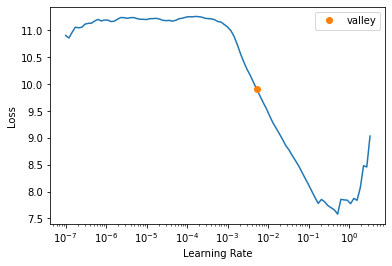

In [13]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_first)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_first, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))

epoch,train_loss,valid_loss,time
0,0.150572,0.206839,00:14
1,0.150693,0.206943,00:14
2,0.150737,0.207096,00:14
3,0.150960,0.207090,00:14
4,0.151560,0.207421,00:14
5,0.152397,0.207589,00:14
6,0.153237,0.208258,00:14
7,0.153600,0.208595,00:14
8,0.154055,0.208968,00:14
9,0.155040,0.209052,00:14


Better model found at epoch 0 with valid_loss value: 0.20683856308460236.
Epoch 10: reducing lr to 8.591347194839051e-05
Epoch 20: reducing lr to 0.00018807736282679062
Epoch 30: reducing lr to 0.00019686695046697975
Epoch 40: reducing lr to 0.0001783910593204253
Epoch 50: reducing lr to 0.00014636080449597928
Better model found at epoch 55 with valid_loss value: 0.20598144829273224.
Epoch 60: reducing lr to 0.00010631454665746575
Better model found at epoch 61 with valid_loss value: 0.20542173087596893.
Better model found at epoch 64 with valid_loss value: 0.20498211681842804.
Better model found at epoch 65 with valid_loss value: 0.20403063297271729.
Epoch 70: reducing lr to 6.517659400552179e-05
Better model found at epoch 71 with valid_loss value: 0.20304356515407562.
Better model found at epoch 74 with valid_loss value: 0.20298919081687927.
Better model found at epoch 75 with valid_loss value: 0.2026664912700653.
Better model found at epoch 76 with valid_loss value: 0.2023616433143

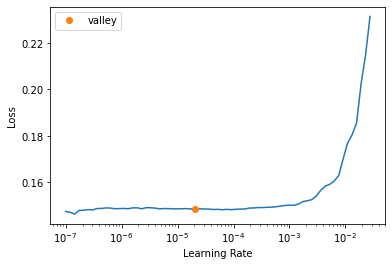

In [14]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_second)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_second, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                        SaveModelCallback(monitor='valid_loss', fname=f'{fname}_best')])

In [15]:
from HW_torch import torch_valid, torch_predict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load(f'models/{fname}_best.pth')
model.load_state_dict(state_dict)

loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size_second, to_device=device)
valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size_second, to_device=device)

print(loss, valid_loss)

0.12805996336473907 0.20069205328341452


In [16]:
predict = torch_predict([model.to(device)], x_test, batch_size_second, to_device=device)
predict = np.reshape(predict, (-1))

prodict: 100% 101/101 [00:04<00:00, 24.63it/s]


In [17]:
df = pd.read_csv('Database/sample_submission.csv', index_col=0)
df['pressure'] = predict

df.to_csv(f'Submission/{fname}.csv')

C:\Users\ffly\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
